# Predict Rain Tomorrow in Australia

##### Python Version: 3.6.8

#### Spark Version: 2.4.3

## A. Creating Spark Session and Loading the Data

### Step 1:  Import Spark Session and Initialize Spark

For this part, I will use and import SparkContext from pyspark, which is the main entry point for Spark Core functionality.

In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# creating spark session with 4 local cores
spark = SparkSession.builder\
.master("local[4]")\
.appName("Assignment 2: Predicting Rain in Australia")\
.getOrCreate()

In [2]:
spark

In [3]:
# importing libraries required

from pyspark.sql.functions import mean
from pyspark.sql.functions import when
from pyspark.sql import functions as F
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

#### Step 2 : Load the dataset and print the schema and total number of entries

In [4]:
# reading csv file
weather = spark.read.csv('weatherAUS.csv',inferSchema =True, header = True)

# printing the number of entries
print("The total number of entries for this dataset is", weather.count())

The total number of entries for this dataset is 142193


In [5]:
weather.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## B. Data Cleaning and Processing


### Step 3: Delete columns from the dataset
Columns which do not contribute towards the prediction of the rain is deleted. The columns deleted are date, location, evaporation, sunshine, cloud9am, cloud3pm, temp9am and temp3pm.



In [6]:
# dropping columns
weather = weather.drop('Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm')

In [7]:
#checking latest columns
weather.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

### Step 4: Printing the number of missing data in each column

For this step, I am printing the number of missing data in each column to find out the total number of missing data.

In [8]:
# loooping through the columns to find the total count of NA for each column
for i in weather.columns:
    count = weather.filter(weather[i] == 'NA').count()
    print('Total null counts for',i,'are:',count)

Total null counts for MinTemp are: 637
Total null counts for MaxTemp are: 322
Total null counts for Rainfall are: 1406
Total null counts for WindGustDir are: 9330
Total null counts for WindGustSpeed are: 9270
Total null counts for WindDir9am are: 10013
Total null counts for WindDir3pm are: 3778
Total null counts for WindSpeed9am are: 1348
Total null counts for WindSpeed3pm are: 2630
Total null counts for Humidity9am are: 1774
Total null counts for Humidity3pm are: 3610
Total null counts for Pressure9am are: 14014
Total null counts for Pressure3pm are: 13981
Total null counts for RainToday are: 1406
Total null counts for RainTomorrow are: 0


### Step 5: Fill the missing data with average value and maximum occurence value

There are two types of data values in this dataset which are numeric and non numeric values. For this step, I am obtaining the average of the columns which consist of numeric values individually and replacing the NA values with the average value of that column. For the non numeric values, I am obtaining the most frequent item of the column and replace the NA values with the most frequent item of that column.

In [9]:
weather.head(1)

[Row(MinTemp='13.4', MaxTemp='22.9', Rainfall='0.6', WindGustDir='W', WindGustSpeed='44', WindDir9am='W', WindDir3pm='WNW', WindSpeed9am='20', WindSpeed3pm='24', Humidity9am='71', Humidity3pm='22', Pressure9am='1007.7', Pressure3pm='1007.1', RainToday='No', RainTomorrow='No')]

##### Step 5.1 : Inputting average of numeric columns

For this step, I am inputting the average of numeric columns and replacing the NA values with the average calculated individually.

In [10]:
# creating a list for columns which have numeric value
numeric_col = [weather['MinTemp'],weather['MaxTemp'],weather['Rainfall'],weather['WindGustSpeed'],weather['WindSpeed9am'],weather['WindSpeed3pm'],weather['Humidity9am'],weather['Humidity3pm'],weather['Pressure9am'],weather['Pressure3pm']]

In [11]:
# looping through the list of column which consist of numeric value to obtain the mean for the columns individually
for i in numeric_col:
  average = weather.select([mean(i)]).show()
  average

+------------------+
|      avg(MinTemp)|
+------------------+
|12.186399728729311|
+------------------+

+----------------+
|    avg(MaxTemp)|
+----------------+
|23.2267841912725|
+----------------+

+------------------+
|     avg(Rainfall)|
+------------------+
|2.3499740743107442|
+------------------+

+------------------+
|avg(WindGustSpeed)|
+------------------+
| 39.98429165757619|
+------------------+

+-----------------+
|avg(WindSpeed9am)|
+-----------------+
|  14.001988000994|
+-----------------+

+-----------------+
|avg(WindSpeed3pm)|
+-----------------+
|18.63757586179718|
+-----------------+

+----------------+
|avg(Humidity9am)|
+----------------+
|68.8438103105705|
+----------------+

+------------------+
|  avg(Humidity3pm)|
+------------------+
|51.482606091656265|
+------------------+

+------------------+
|  avg(Pressure9am)|
+------------------+
|1017.6537584159615|
+------------------+

+------------------+
|  avg(Pressure3pm)|
+------------------+
|1015.2582035

In [12]:
#inputting the NA values for the column with the average values calculated above

updatedmint = weather.withColumn("MinTemp",F.when(F.col("MinTemp") == 'NA',12.2).otherwise(F.col("MinTemp")))
updatedmaxt = updatedmint.withColumn("MaxTemp",F.when(F.col("MaxTemp") == 'NA',23.2).otherwise(F.col("MaxTemp")))
updatedrainf = updatedmaxt.withColumn("Rainfall",F.when(F.col("Rainfall") == 'NA',2.3).otherwise(F.col("Rainfall")))
updatedwind = updatedrainf.withColumn("WindGustSpeed",F.when(F.col("WindGustSpeed") == 'NA',40.0).otherwise(F.col("WindGustSpeed")))
updatedwinds9 = updatedwind.withColumn("WindSpeed9am",F.when(F.col("WindSpeed9am") == 'NA',14.0).otherwise(F.col("WindSpeed9am")))
updatedwinds3 = updatedwinds9.withColumn("WindSpeed3pm",F.when(F.col("WindSpeed3pm") == 'NA',18.6).otherwise(F.col("WindSpeed3pm")))
updatedhum9 = updatedwinds3.withColumn("Humidity9am",F.when(F.col("Humidity9am") == 'NA',68.8).otherwise(F.col("Humidity9am")))
updatedhum3 = updatedhum9.withColumn("Humidity3pm",F.when(F.col("Humidity3pm") == 'NA',51.5).otherwise(F.col("Humidity3pm")))
updatedpres9 = updatedhum3.withColumn("Pressure9am",F.when(F.col("Pressure9am") == 'NA',1017.7).otherwise(F.col("Pressure9am")))
inputted_numeric = updatedpres9.withColumn("Pressure3pm",F.when(F.col("Pressure3pm") == 'NA',1015.3).otherwise(F.col("Pressure3pm")))

##### Step 5.2 Inputting average of non numeric columns

For this step, I am inputting the most frequent word of non numeric columns and replacing the NA values with the most frequent word

In [13]:
# obtaining highest count for column Windgustdir through getting the count and sorting by descending value
weather.withColumn('Windgustdir', f.explode(f.split(f.col('WindGustDir'), ' ')))\
    .groupBy('Windgustdir')\
    .count()\
    .sort('count', ascending=False)\
    .show(1)
                   

+-----------+-----+
|Windgustdir|count|
+-----------+-----+
|          W| 9780|
+-----------+-----+
only showing top 1 row



In [14]:
# obtaining highest count for column Winddir9am through getting the count and sorting by descending value
weather.withColumn('Winddir9am', f.explode(f.split(f.col('WindDir9am'), ' ')))\
    .groupBy('Winddir9am')\
    .count()\
    .sort('count', ascending=False)\
    .show(1)

+----------+-----+
|Winddir9am|count|
+----------+-----+
|         N|11393|
+----------+-----+
only showing top 1 row



In [15]:
# obtaining highest count for column Winddir3pm through getting the count and sorting by descending value
weather.withColumn('count_winddir3pm', f.explode(f.split(f.col('WindDir3pm'), ' ')))\
    .groupBy('count_winddir3pm')\
    .count()\
    .sort('count', ascending=False)\
    .show(1)

+----------------+-----+
|count_winddir3pm|count|
+----------------+-----+
|              SE|10663|
+----------------+-----+
only showing top 1 row



In [16]:
# obtaining highest count for column rain_today through getting the count and sorting by descending value
weather.withColumn('Rain_today', f.explode(f.split(f.col('RainToday'), ' ')))\
    .groupBy('Rain_today')\
    .count()\
    .sort('count', ascending=False)\
    .show(1)

+----------+------+
|Rain_today| count|
+----------+------+
|        No|109332|
+----------+------+
only showing top 1 row



In [17]:
# obtaining highest count for column rain_tomorrow through getting the count and sorting by descending value
weather.withColumn('Rain_tomorrow', f.explode(f.split(f.col('RainTomorrow'), ' ')))\
    .groupBy('Rain_tomorrow')\
    .count()\
    .sort('count', ascending=False)\
    .show(1)

+-------------+------+
|Rain_tomorrow| count|
+-------------+------+
|           No|110316|
+-------------+------+
only showing top 1 row



In [18]:
#inputting the NA values for the column with the most frequent word calculated above

updatedwindgust = inputted_numeric.withColumn("WindGustDir",F.when(F.col("WindGustDir") == 'NA','W').otherwise(F.col("WindGustDir")))
updatedwindir9 = updatedwindgust.withColumn("WindDir9am",F.when(F.col("WindDir9am") == 'NA','N').otherwise(F.col("WindDir9am")))
updatedwindir3 = updatedwindir9.withColumn("WindDir3pm",F.when(F.col("WindDir3pm") == 'NA','SE').otherwise(F.col("WindDir3pm")))
updatedraint = updatedwindir3.withColumn("RainToday",F.when(F.col("RainToday") == 'NA','No').otherwise(F.col("RainToday")))
inputted_weather = updatedraint.withColumn("RainTomorrow",F.when(F.col("RainTomorrow") == 'NA','No').otherwise(F.col("RainTomorrow")))

### Step 6: Data Transformation 

Data transformation is done so that it will be useful to process by the machine learning algorithm. Numerical value columns are firstly transformed by type casting them to double as they are defined as string. Then, the non numerical value column are converted to numbers using stringindexer.

In [19]:
# looking at the dataframe datatype
inputted_weather.dtypes

[('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [20]:
# list of numeric column
numeric_col = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']

In [21]:
# looping through the numerical columns and transforming them by type casting them to make them double 
for i in numeric_col:
    inputted_weather = inputted_weather.withColumn(i, inputted_weather[i].cast(DoubleType()))
  

In [22]:
# checking updated data type
inputted_weather.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'double'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [23]:
# list of non numeric columns
non_numeric = ['WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow']

In [24]:
# looping through non numeric columns and converting them into numbers using stringindexer

for i in non_numeric:
    # creating a new column with converted number outputs
    l_indexer = StringIndexer(inputCol= i , outputCol= 'category' + i )
    inputted_weather = l_indexer.fit(inputted_weather).transform(inputted_weather)

In [25]:
inputted_weather.head(2)

[Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, WindGustDir='W', WindGustSpeed=44.0, WindDir9am='W', WindDir3pm='WNW', WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, RainToday='No', RainTomorrow='No', categoryWindGustDir=0.0, categoryWindDir9am=6.0, categoryWindDir3pm=7.0, categoryRainToday=0.0, categoryRainTomorrow=0.0),
 Row(MinTemp=7.4, MaxTemp=25.1, Rainfall=0.0, WindGustDir='WNW', WindGustSpeed=44.0, WindDir9am='NNW', WindDir3pm='WSW', WindSpeed9am=4.0, WindSpeed3pm=22.0, Humidity9am=44.0, Humidity3pm=25.0, Pressure9am=1010.6, Pressure3pm=1007.8, RainToday='No', RainTomorrow='No', categoryWindGustDir=9.0, categoryWindDir9am=9.0, categoryWindDir3pm=3.0, categoryRainToday=0.0, categoryRainTomorrow=0.0)]

In [26]:
# dropping initial non numerical columns 
inputted_weather = inputted_weather.drop('WindGustDir','WindDir9am','WindDir3pm','RainToday')

In [27]:
inputted_weather.head(2)

[Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, RainTomorrow='No', categoryWindGustDir=0.0, categoryWindDir9am=6.0, categoryWindDir3pm=7.0, categoryRainToday=0.0, categoryRainTomorrow=0.0),
 Row(MinTemp=7.4, MaxTemp=25.1, Rainfall=0.0, WindGustSpeed=44.0, WindSpeed9am=4.0, WindSpeed3pm=22.0, Humidity9am=44.0, Humidity3pm=25.0, Pressure9am=1010.6, Pressure3pm=1007.8, RainTomorrow='No', categoryWindGustDir=9.0, categoryWindDir9am=9.0, categoryWindDir3pm=3.0, categoryRainToday=0.0, categoryRainTomorrow=0.0)]

In [28]:
# checking updated data type of dataframe
inputted_weather.dtypes

[('MinTemp', 'double'),
 ('MaxTemp', 'double'),
 ('Rainfall', 'double'),
 ('WindGustSpeed', 'double'),
 ('WindSpeed9am', 'double'),
 ('WindSpeed3pm', 'double'),
 ('Humidity9am', 'double'),
 ('Humidity3pm', 'double'),
 ('Pressure9am', 'double'),
 ('Pressure3pm', 'double'),
 ('RainTomorrow', 'string'),
 ('categoryWindGustDir', 'double'),
 ('categoryWindDir9am', 'double'),
 ('categoryWindDir3pm', 'double'),
 ('categoryRainToday', 'double'),
 ('categoryRainTomorrow', 'double')]

### Step 7: Create the feature vector and divide the dataset

For this step, I am creating feature vector with the columns in the dataset. To create the feature vector,I have excluded the column (categoryRainTomorrow) that I will be using for testing the accuracy of my model. After the creation of the feature vector, I've split my dataset randomly and between 70 percent and 30 percent

In [29]:
numeric_col

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm']

In [30]:
# using vectorassembler function which is a transformer to combine the list of features to a single vector column.
# the column which i would like to predict is excluded from the vector
vector_assembler = VectorAssembler(\

inputCols=['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','categoryWindGustDir', 'categoryWindDir9am', 'categoryWindDir3pm', 'categoryRainToday'],\
outputCol=  'Prob_RainTomorrow')

#transforming to vector feature
df_temp = vector_assembler.transform(inputted_weather)
df_temp.show(3)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+------------+-------------------+------------------+------------------+-----------------+--------------------+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainTomorrow|categoryWindGustDir|categoryWindDir9am|categoryWindDir3pm|categoryRainToday|categoryRainTomorrow|   Prob_RainTomorrow|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+------------+-------------------+------------------+------------------+-----------------+--------------------+--------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|          No|                0.0|               6.0|               7.0|              0.0|                 0.0|[13.4,22.9,0.6,44...|
|    7.4|   25.1

In [31]:
# splitting dataset between training and testdata. 70% is allocated to training data while 30% is allocated to testdata
(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])

## C. Apply Machine Learning Algorithms

### Step 8: Apply Machine Learning Classification Algorithms on the dataset and compare their accuracy

For this step, 4 machine learning classfication algorithms consisting of  Decision tree, random forest, logistic regression and gradient boosting were used and their accuracy are compared. 

####  Applying Decision Tree Classifier

In [32]:
# applying decision tree classifier algorithm 
dt = DecisionTreeClassifier(labelCol='categoryRainTomorrow' , featuresCol="Prob_RainTomorrow")
model = dt.fit(trainingData)

dect_predictions = model.transform(testData)

dect_predictions.select("prediction", "categoryRainTomorrow").show(5)

evaluator = MulticlassClassificationEvaluator(\

labelCol="categoryRainTomorrow", predictionCol="prediction",\

metricName="accuracy")

#evaluating accuracy of predictions
accuracy_decisiontree = evaluator.evaluate(dect_predictions)

round_acc_dt = round(accuracy_decisiontree*100,2)

print("Test Error = %g " % (1.0 - accuracy_decisiontree))
print("Accuracy Total",round_acc_dt,'%')

+----------+--------------------+
|prediction|categoryRainTomorrow|
+----------+--------------------+
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 5 rows

Test Error = 0.163926 
Accuracy Total 83.61 %


#### Applying Random Forest Classifier

In [33]:
# applying random tree classifier algorithm

rf = RandomForestClassifier(labelCol= 'categoryRainTomorrow',\
featuresCol="Prob_RainTomorrow", numTrees=10)

model = rf.fit(trainingData)

rfor_predictions = model.transform(testData)

rfor_predictions.select("prediction",'categoryRainTomorrow' ).show(5)

# evaluating accuracy of prediction
evaluator =\
MulticlassClassificationEvaluator(labelCol="categoryRainTomorrow",\
predictionCol="prediction", metricName="accuracy")

accuracy_rf = evaluator.evaluate(rfor_predictions)
round_acc_rf = round(accuracy_rf*100,2)

print("Test Error = %g" % (1.0 - accuracy_rf))
print("Accuracy Total:",round_acc_rf,'%')

+----------+--------------------+
|prediction|categoryRainTomorrow|
+----------+--------------------+
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 5 rows

Test Error = 0.164114
Accuracy Total: 83.59 %


#### Applying Logistic Regression

In [34]:
# applying logistic regression algorithm

dt = LogisticRegression(labelCol='categoryRainTomorrow' , featuresCol="Prob_RainTomorrow")
model = dt.fit(trainingData)

logr_predictions = model.transform(testData)

logr_predictions.select("prediction", "categoryRainTomorrow").show(5)

evaluator = MulticlassClassificationEvaluator(\

labelCol="categoryRainTomorrow", predictionCol="prediction",\

metricName="accuracy")

#evaluating accuracy of prediction
accuracy_lr = evaluator.evaluate(logr_predictions)
round_acc_lr = round(accuracy_lr*100,2)

print("Test Error = %g " % (1.0 - accuracy_lr))
print("Accuracy Total:",round_acc_lr,'%')

+----------+--------------------+
|prediction|categoryRainTomorrow|
+----------+--------------------+
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 5 rows

Test Error = 0.160604 
Accuracy Total: 83.94 %


#### Applying GBTClassifier

In [35]:
# applying gradient boost algorithm

dt = GBTClassifier(labelCol='categoryRainTomorrow' , featuresCol="Prob_RainTomorrow")
model = dt.fit(trainingData)

gbt_predictions = model.transform(testData)

gbt_predictions.select("prediction", "categoryRainTomorrow").show(5)

evaluator = MulticlassClassificationEvaluator(\

labelCol="categoryRainTomorrow", predictionCol="prediction",\

metricName="accuracy")

# evaluating accuracy of prediction
accuracy_GBT = evaluator.evaluate(gbt_predictions)
round_acc_GBT = round(accuracy_GBT*100,2)

print("Test Error = %g " % (1.0 - accuracy_GBT))
print("Accuracy Total:",round_acc_GBT,'%')

+----------+--------------------+
|prediction|categoryRainTomorrow|
+----------+--------------------+
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
|       0.0|                 0.0|
+----------+--------------------+
only showing top 5 rows

Test Error = 0.157259 
Accuracy Total: 84.27 %


#### Plotting graph to demonstrate comparison of accuracy

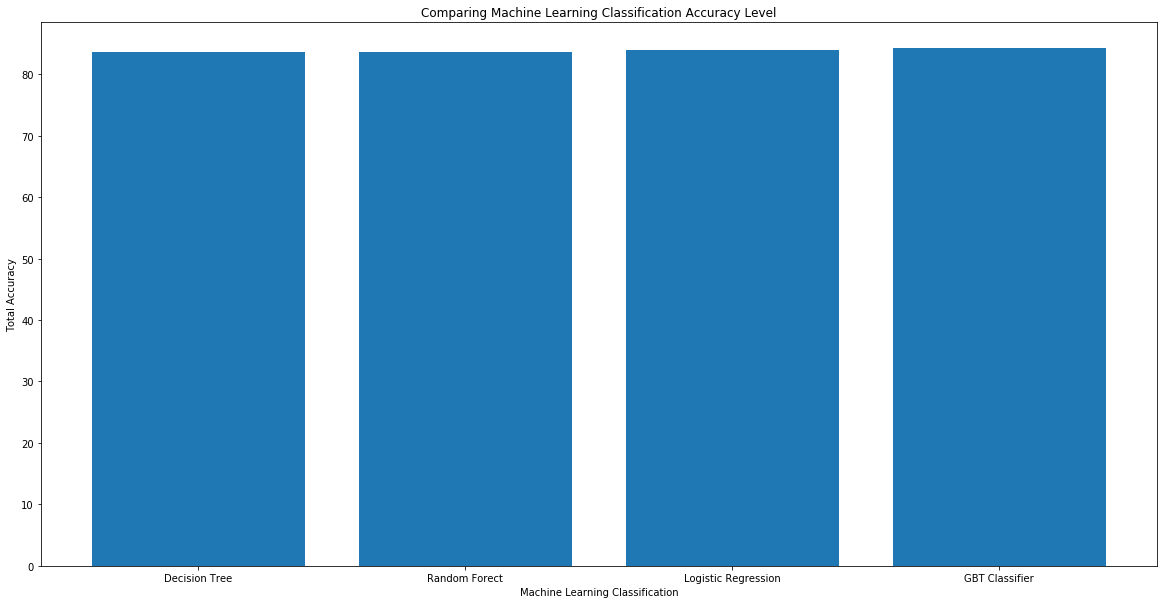

In [36]:
ml_algo = ['Decision Tree','Random Forect','Logistic Regression','GBT Classifier']
total_accuracy = [round_acc_dt,round_acc_rf,round_acc_lr,round_acc_GBT]

plt.figure(figsize = (20,10))
plt.bar(ml_algo, total_accuracy)
plt.xlabel('Machine Learning Classification')
plt.ylabel('Total Accuracy')
plt.title('Comparing Machine Learning Classification Accuracy Level')
plt.show()



From the plot above, we can see that the 4 algorithm have the similiar total accuracy. GBT Classifier has the highest accuracy with an accuracy of 84.1%.

### Step 9: Calculate Confusion Matrix 

The confusion matrix is calculated using the confusion matrix function to obtain the true positive, true negative, false positive and false negative values. The precision and recall score for each model is calculated with the true positive, true negative, false positive and false negative values obtained from the confusion matrix. Precision score is calculated to find out the percentage of which the results are relevant whereas recall score is used to find out the percentage of total relevant results correctly classified by the algorithm. F1 score, the weighted average is obtained from the values of the precision and recall score. F1 is used to measure the test's accuracy.


In [37]:
# getting rdd list of values of rain tomorrow and predicted values and putting it to multiclassmetrics function which
# is an evaluator for multiclass classification
dect_predict= dect_predictions.select("prediction", "categoryRainTomorrow").rdd
dect_metrics = MulticlassMetrics(dect_predict)


rfor_predict= rfor_predictions.select("prediction", "categoryRainTomorrow").rdd
rfor_metrics = MulticlassMetrics(rfor_predict)


logr_predict= logr_predictions.select("prediction", "categoryRainTomorrow").rdd
logr_metrics = MulticlassMetrics(logr_predict)


gbt_predict= gbt_predictions.select("prediction", "categoryRainTomorrow").rdd
gbt_metrics = MulticlassMetrics(gbt_predict)



In [38]:
# converting evaluated matrix of confusion matrix to array
dect_val = dect_metrics.confusionMatrix().toArray()
rfot_val = rfor_metrics.confusionMatrix().toArray()
logr_val = logr_metrics.confusionMatrix().toArray()
gbt_val = gbt_metrics.confusionMatrix().toArray()


In [39]:
# function for calculation of precision, recall and f1 score
def precision(true_pos,false_pos):
    precision = true_pos/ (true_pos + false_pos)
    return precision

def recall(true_pos,false_neg):
    recall = true_pos/(true_pos + false_neg)
    return recall
    
def f1score(precision,recall):
    f1 = 2*(precision * recall)/(precision + recall )
    return f1
    
    

#### Calculating precision, recall and f1 score for decision tree

In [40]:
# passing through precision, recall and f1 score function with values from individual machine learning confusion matrix
# values of true positive, false positive and false negative to calculate precision, recall and f1 score

# passing decision tree's true positive and false positive value from confusion matrix into precision function to calculate
# precision
precision_dect = precision(dect_val[1][1],dect_val[0][1])
# passing decision tree's true positive and false negative value from confusion matrix into precision function to calculate
# recall
recall_dect = recall(dect_val[1][1],dect_val[1][0])
# passing decision tree precision and recall values to f1score function to get f1 score
f1_dect = f1score(precision_dect,recall_dect)

print('Precision score for decision tree:',precision_dect)
print('Recall score for decision tree:',recall_dect)
print('F1 score for decision tree:', f1_dect)

Precision score for decision tree: 0.7434514637904468
Recall score for decision tree: 0.4069154543537845
F1 score for decision tree: 0.5259572148794114


#### Calculating precision, recall and f1 score for random forest

In [41]:
# passing through precision, recall and f1 score function with values from individual machine learning confusion matrix
# values of true positive, false positive and false negative to calculate precision, recall and f1 score

# passing random forest's true positive and false positive value from confusion matrix into precision function to
#calculate precision
precision_rfot = precision(rfot_val[1][1],rfot_val[0][1])
# passing random forest's true positive and false negative value from confusion matrix into precision function to
# calculate recall
recall_rfot = recall(rfot_val[1][1],rfot_val[1][0])
# passing random forest precision and recall values to f1score function to get f1 score
f1_rfot = f1score(precision_rfot,recall_rfot)

print('Precision score for random forest:',precision_rfot)
print('Recall score for random forest:',recall_rfot)
print('F1 score for random forest:', f1_rfot)

Precision score for random forest: 0.7686567164179104
Recall score for random forest: 0.380033733923677
F1 score for random forest: 0.5086060948081265


#### Calculating precision, recall and f1 score for logistic regression

In [42]:
#passing through precision, recall and f1 score function with values from individual machine learning confusion matrix
# values of true positive, false positive and false negative to calculate precision, recall and f1 score

# passing logistic regression's true positive and false positive value from confusion matrix into precision function
#to calculate precision
precision_logr = precision(logr_val[1][1],logr_val[0][1])
# passing logistic regression's true positive and false negative value from confusion matrix into precision function to
# calculate recall
recall_logr = recall(logr_val[1][1],logr_val[1][0])
# passing logistic regression precision and recall values to f1score function to get f1 score
f1_logr = f1score(precision_logr,recall_logr)

print('Precision score for logistic regression:',precision_logr)
print('Recall score for logistic regression:',recall_logr)
print('F1 score for logistic regression:', f1_logr)

Precision score for logistic regression: 0.7224537422903817
Recall score for logistic regression: 0.45688382880033734
F1 score for logistic regression: 0.559767516951889


#### Calculating precision, recall and f1 score for gradient boost

In [43]:
#passing through precision, recall and f1 score function with values from individual machine learning confusion matrix
# values of true positive, false positive and false negative to calculate precision, recall and f1 score

# passing gradient boost's true positive and false positive value from confusion matrix into precision function
#to calculate precision
precision_gbt = precision(gbt_val[1][1],gbt_val[0][1])
# passing gradient boost's true positive and false negative value from confusion matrix into precision function to
# calculate recall
recall_gbt = recall(gbt_val[1][1],gbt_val[1][0])
# passing gradient boost precision and recall values to f1score function to get f1 score
f1_gbt = f1score(precision_gbt,recall_gbt)

print('Precision score for gradient boost:',precision_gbt)
print('Recall score for gradient boost:',recall_gbt)
print('F1 score for gradient boost:', f1_gbt)

Precision score for gradient boost: 0.731358024691358
Recall score for gradient boost: 0.4683744465528147
F1 score for gradient boost: 0.5710429920956237


The accuracy of the model can be improved by:

1. Using multiple imputation to place in missing values instead of mean values. The flaw of inputting mean values is that  substituting the identical score for a large portion of the sample artificially decreases the variance of the variable , and makes the effect  of missing data more profound when the percentage of missing data increases. Using multiple imputation will reduce the bias and increase accuracy. 

2. Adding more data. A larger data set allows better accuracy as you are able to train more data and obtain a more accurate output
